In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , Conv2D, MaxPooling2D, Flatten,Conv1D,MaxPooling1D,LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder  # Make sure this im

2025-02-27 06:55:51.827002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 06:55:51.830881: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 06:55:51.840776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740639351.856542  668757 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740639351.861166  668757 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 06:55:51.879764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
DATASET_PATH = "data/Data/genres_original"
GENRES = ['blues', 'classical', 'jazz', 'pop', 'rock']
SAMPLE_RATE = 22050

for dirname, _, filenames in os.walk('data/Data/genres_original'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/Data/genres_original/disco/disco.00042.wav
data/Data/genres_original/disco/disco.00024.wav
data/Data/genres_original/disco/disco.00033.wav
data/Data/genres_original/disco/disco.00026.wav
data/Data/genres_original/disco/disco.00064.wav
data/Data/genres_original/disco/disco.00002.wav
data/Data/genres_original/disco/disco.00099.wav
data/Data/genres_original/disco/disco.00059.wav
data/Data/genres_original/disco/disco.00087.wav
data/Data/genres_original/disco/disco.00006.wav
data/Data/genres_original/disco/disco.00004.wav
data/Data/genres_original/disco/disco.00034.wav
data/Data/genres_original/disco/disco.00056.wav
data/Data/genres_original/disco/disco.00083.wav
data/Data/genres_original/disco/disco.00057.wav
data/Data/genres_original/disco/disco.00011.wav
data/Data/genres_original/disco/disco.00091.wav
data/Data/genres_original/disco/disco.00073.wav
data/Data/genres_original/disco/disco.00044.wav
data/Data/genres_original/disco/disco.00005.wav
data/Data/genres_original/disco/disco.00

In [3]:
def extract_features(file_path, sr=22050, duration=30):
    """
    สกัดคุณลักษณะ Mel-spectrogram จากไฟล์เสียง
    
    Parameters:
        file_path (str): เส้นทางไฟล์เสียง
        sr (int): อัตราการสุ่มตัวอย่าง
        duration (int): ระยะเวลาที่ใช้ (วินาที)
        
    Returns:
        mel_spectrogram (np.array): Mel-spectrogram
    """
    # Ensure numpy is imported at the function level if not available globally
    import numpy as np
    
    try:
        # Try the default loading method
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        try:
            # Try with audioread backend explicitly
            import warnings
            warnings.filterwarnings('ignore')
            y, sr = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')
        except Exception as e:
            print(f"Second attempt failed: {e}")
            try:
                # Try with pydub as last resort
                from pydub import AudioSegment
                
                audio = AudioSegment.from_file(file_path)
                samples = np.array(audio.get_array_of_samples())
                # Convert to float32 and normalize
                if audio.channels == 2:
                    samples = samples.reshape((-1, 2))
                    # Take average of both channels
                    samples = samples.mean(axis=1)
                y = samples.astype(np.float32) / np.iinfo(samples.dtype).max
                
                if sr != audio.frame_rate:
                    # Need to resample
                    import resampy
                    y = resampy.resample(y, audio.frame_rate, sr)
            except Exception as e:
                print(f"All loading methods failed for {file_path}: {e}")
                # Return empty array with correct shape
                y = np.zeros(sr * duration)
    
    # Ensure the audio is the right length
    if len(y) < sr * duration:
        # Pad if too short
        y = np.pad(y, (0, sr * duration - len(y)))
    elif len(y) > sr * duration:
        # Trim if too long
        y = y[:sr * duration]
    
    # สกัด Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_fft=2048, 
        hop_length=512, 
        n_mels=128
    )
    
    # แปลงเป็น Decibel scale
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram

In [4]:
# การโหลดและจัดเตรียมชุดข้อมูล
def prepare_dataset(dataset_path, genres):
    """
    เตรียมชุดข้อมูลสำหรับการฝึกฝน
    
    Parameters:
        dataset_path (str): เส้นทางไปยังโฟลเดอร์ที่มีไฟล์เสียง
        genres (list): รายการประเภทดนตรีที่ต้องการจำแนก
        
    Returns:
        X (np.array): อาร์เรย์ของคุณลักษณะ
        y (np.array): อาร์เรย์ของป้ายกำกับ
    """
    features = []
    labels = []
    
    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        for file_name in os.listdir(genre_path):
            if file_name.endswith('.wav') or file_name.endswith('.mp3'):
                file_path = os.path.join(genre_path, file_name)
                print(f'Extracting features from {file_path}')
                mel_spec = extract_features(file_path)
                features.append(mel_spec)
                labels.append(genre)
    
    # แปลงป้ายกำกับเป็นตัวเลข
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)
    
    # แปลงลิสต์เป็น numpy array
    X = np.array(features)
    y = np.array(y)
    
    return X, y, label_encoder

In [5]:
# สร้างชุดข้อมูลสำหรับการฝึกฝนและทดสอบ
def create_train_test_data(X, y, test_size=0.2, val_size=0.2):
    """
    แบ่งข้อมูลเป็นชุดฝึกฝน ตรวจสอบ และทดสอบ
    
    Parameters:
        X (np.array): อาร์เรย์ของคุณลักษณะ
        y (np.array): อาร์เรย์ของป้ายกำกับ
        test_size (float): สัดส่วนของชุดทดสอบ
        val_size (float): สัดส่วนของชุดตรวจสอบ
        
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    # แบ่งข้อมูลออกเป็นชุดฝึกฝนและทดสอบก่อน
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    # จากชุดฝึกฝน แบ่งออกเป็นชุดฝึกฝนและตรวจสอบ
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, random_state=42
    )
    
    # ปรับรูปร่างข้อมูลให้เหมาะกับ CRNN (samples, time_steps, features, channels)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [6]:
# ฟังก์ชันแสดงตัวอย่าง Mel-spectrogram
def plot_mel_spectrogram(mel_spectrogram, title='Mel Spectrogram'):
    """
    แสดง Mel-spectrogram ด้วย matplotlib
    
    Parameters:
        mel_spectrogram (np.array): Mel-spectrogram ที่ต้องการแสดง
        title (str): ชื่อกราฟ
    """
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00080.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00036.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00043.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00029.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00082.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00056.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00016.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00044.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00042.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blues.00035.wav
Extracting features from /home/bill/code/AI/data/Data/genres_original/blues/blue

/tmp/ipykernel_668757/1431170940.py:18: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/home/bill/anaconda3/envs/tf-env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading /home/bill/code/AI/data/Data/genres_original/jazz/jazz.00054.wav: 
Second attempt failed: 
All loading methods failed for /home/bill/code/AI/data/Data/genres_original/jazz/jazz.00054.wav: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable

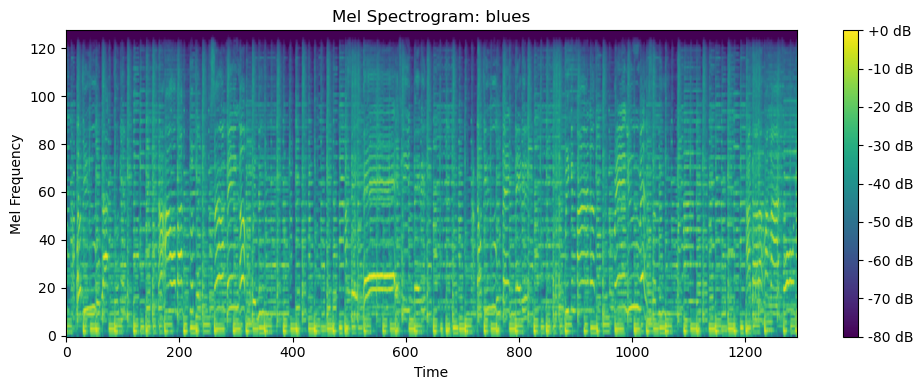

รูปร่างของข้อมูลฝึกฝน: (638, 128, 1292, 1)
รูปร่างของข้อมูลตรวจสอบ: (160, 128, 1292, 1)
รูปร่างของข้อมูลทดสอบ: (200, 128, 1292, 1)


In [7]:
if __name__ == '__main__':
    dataset_path = '/home/bill/code/AI/data/Data/genres_original'
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
              'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    # เตรียมข้อมูล
    X, y, label_encoder = prepare_dataset(dataset_path, genres)
    print(f"รูปร่างของคุณลักษณะ: {X.shape}")
    print(f"รูปร่างของป้ายกำกับ: {y.shape}")
    
    # แสดงตัวอย่าง Mel-spectrogram
    plot_mel_spectrogram(X[0], title=f'Mel Spectrogram: {label_encoder.inverse_transform([y[0]])[0]}')
    
    # สร้างชุดข้อมูลฝึกฝน ตรวจสอบ และทดสอบ
    X_train, X_val, X_test, y_train, y_val, y_test = create_train_test_data(X, y)
    print(f"รูปร่างของข้อมูลฝึกฝน: {X_train.shape}")
    print(f"รูปร่างของข้อมูลตรวจสอบ: {X_val.shape}")
    print(f"รูปร่างของข้อมูลทดสอบ: {X_test.shape}")

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Reshape, Dense, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_crnn_model(input_shape, num_classes):
    """
    สร้างโมเดล CRNN สำหรับการจำแนกดนตรี
    
    Parameters:
        input_shape (tuple): รูปร่างของอินพุต (time_steps, features, channels)
        num_classes (int): จำนวนประเภทดนตรี
        
    Returns:
        model (tf.keras.Model): โมเดล CRNN
    """
    # อินพุตเลเยอร์
    inputs = Input(shape=input_shape)
    
    # ส่วน CNN 
    # ชั้นที่ 1
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    # ชั้นที่ 2
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    # ชั้นที่ 3
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    # ชั้นที่ 4
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(0.3)(x)
    
    # เปลี่ยนรูปร่างสำหรับ RNN
    # ทำให้อยู่ในรูปแบบ (time_steps, features)
    # ลำดับความสำคัญ: เวลาอยู่ตามแกนความกว้าง (width) และทุกความถี่รวมเป็นคุณลักษณะ
    _, height, width, channels = x.shape
    x = Reshape((width, height * channels))(x)
    
    # ส่วน RNN - จับความสัมพันธ์เชิงลำดับตามเวลา
    # ใช้ Bidirectional LSTM เพื่อตรวจจับรูปแบบทั้งไปข้างหน้าและย้อนกลับ
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    
    # LSTM ชั้นที่ 2 ไม่ส่งคืนลำดับ แต่ส่งคืนเฉพาะสถานะสุดท้าย
    x = Bidirectional(LSTM(256, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    
    # ชั้นเชื่อมต่อแบบเต็ม (Fully Connected Layer)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    # ชั้นเอาต์พุต
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # สร้างโมเดล
    model = Model(inputs=inputs, outputs=outputs)
    
    # คอมไพล์โมเดล
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
def train_crnn_model(model, X_train, y_train, X_val, y_val, X_test, batch_size=32, epochs=100,model_path='crnn_music_genre_model'):
    """
    ฝึกฝนโมเดล CRNN
    
    Parameters:
        model (tf.keras.Model): โมเดล CRNN
        X_train, y_train: ข้อมูลฝึกฝน
        X_val, y_val: ข้อมูลตรวจสอบ
        X_test: ข้อมูลทดสอบ
        batch_size (int): ขนาดของ batch
        epochs (int): จำนวนรอบการฝึกฝน
        
    Returns:
        history: ประวัติการฝึกฝน
    """
    # กำหนด callbacks
    callbacks = [
        # หยุดก่อนกำหนดเมื่อ validation loss ไม่ลดลง
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        # บันทึกโมเดลที่ดีที่สุด
        ModelCheckpoint(
            'best_crnn_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        # ลดอัตราการเรียนรู้เมื่อ validation loss ไม่ลดลง
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Trim spectrograms to fixed width
    X_train = X_train[:, :, :259]  # ตัดความกว้างของ spectrogram
    X_val = X_val[:, :, :259]
    X_test = X_test[:, :, :259]


    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )
        # บันทึกโมเดลหลังการฝึกฝน
    model.save(f'{model_path}_final.keras')
    
    # บันทึก history เป็นไฟล์ numpy
    np.save(f'{model_path}_history.npy', history.history)
    
    print(f"โมเดลถูกบันทึกไว้ที่ '{model_path}_final.keras'")
    print(f"ประวัติการฝึกฝนถูกบันทึกไว้ที่ '{model_path}_history.npy'")
    
    return history, X_train, X_val, X_test  # Return modified data for later use




In [ ]:
input_shape = (128, 259, 1)  # (freq_bins, time_frames, channels)
num_classes = 10  # จำนวนประเภทดนตรี
model = create_crnn_model(input_shape, num_classes)
model.summary()
history, X_train_processed, X_val_processed, X_test_processed = train_crnn_model(
        model, X_train, y_train, X_val, y_val, X_test, 
        batch_size=32, epochs=100
)

2025-02-27 06:56:23.841078: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 259, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 259, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 259, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 129, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 2048)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 512)         │     4,720,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,65

 Total params: 8,117,002 (30.96 MB)

 Trainable params: 8,115,082 (30.96 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1518 - loss: 2.3033

20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.1527 - loss: 2.3018 - val_accuracy: 0.1000 - val_loss: 2.3375 - learning_rate: 1.0000e-04
Epoch 2/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2412 - loss: 2.1591